In [474]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit.circuit.library import XGate, ZGate
from qiskit_aer import Aer, AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

In [475]:
num_input = 3
num_qubits = num_input * 2

In [476]:
def multi_cx(qc, controls, anti_controls, target):
    num_controls = len(controls) + len(anti_controls)
    ctrl_state = get_ctrl_state(controls, anti_controls)
    new_gate = XGate().control(num_controls, ctrl_state=ctrl_state)
    # print(f"MX: Controls: {controls}, anti_controls: {anti_controls}, target: {target}, ctrl_state: {ctrl_state}")
    
    # FIX later weird thing, controll is first and anti is second because before when use of x, opposite in z thing.
    sorted_controls = sorted(controls + anti_controls)
    qc.append(new_gate, sorted_controls + [target])
    
    return qc

In [477]:
def multi_cz(qc, controls, anti_controls, target):
    num_controls = len(controls) + len(anti_controls)
    ctrl_state = get_ctrl_state(controls, anti_controls)
    new_gate = ZGate().control(num_controls, label=None, ctrl_state=ctrl_state)
    # new_gate = XGate().control(num_controls, label=None, ctrl_state=ctrl_state)
    # print(f"MZ: Controls: {controls}, anti_controls: {anti_controls}, target: {target}, ctrl_state: {ctrl_state}")
    
    sorted_controls = sorted(controls + anti_controls)
    qc.append(new_gate, sorted_controls + [target])
    
    
    return qc

In [478]:
def get_ctrl_state(controls, anti_controls):
    # num_controls = len(controls) + len(anti_controls)
    ctrl_state = ''
    for i in range(num_qubits - 1, -1, -1):
        if i in controls:
            ctrl_state += '1'
        elif i in anti_controls:
            ctrl_state += '0'
    return ctrl_state

In [479]:
def L_op(qc, qubits_to_rot, num_input, ls):
    for i in range(qubits_to_rot):
        multi_cx(qc, [(qubits_to_rot - 1)], ls[i:], num_input + i)

In [480]:
def R_op(qc, qubits_to_rot, num_input, ls):
    for i in range(qubits_to_rot):
        multi_cx(qc, [(qubits_to_rot - 1)] + ls[i:], [], num_input + i)

In [481]:
def szegedy_step(qc):
    # L rotation
    ls = [num_input + i for i in range(1, num_input)]
    # print(f"num_input: {num_input} ls: {ls[0:]}")
    for i in range(num_input, 0, -1):
        # print(f"i: {i} qubits_l_op: {qubits_l_op}, ls: {ls[:(i - 1)]}")
        L_op(qc, i, num_input, ls[:(i - 1)])

    # middle part
    # for i in range(num_input - 2):
    #     multi_cx(qc, [], [num_input + 0], num_input + 1 + i)
    multi_cx(qc, [], [num_input + 0], num_input * 2 - 2)
        

    qc.h(num_input + 0) # no change

    # num_input + 1 to num_input + (num_input - 1) not included
    # multi_cz(qc, [num_input + i for i in range(1, (num_input -1))], [num_input + 0], num_input * 2 - 1) # this is as paper
    multi_cz(qc, [num_input + 0], [num_input * 2 - 2], num_input * 2 - 1) # this is the opposite of paper

    qc.h(num_input + 0) # no change

    # for i in range(num_input - 2):
    #     multi_cx(qc, [], [num_input + 0], num_input + 1 + i)
    multi_cx(qc, [], [num_input + 0], num_input * 2 - 2)
    

    # R rotation
    for i in range(num_input, 0, -1):
        # print(f"i: {i} qubits_r_op: {qubits_r_op}, ls: {ls[:(i - 1)]}")
        R_op(qc, i, num_input, ls[:(i - 1)])

    for i in range(num_input-1, -1, -1):
        qc.swap(i, num_input + i)
    # qc.swap(2, num_input + 2)
    # qc.swap(1, num_input + 1)
    # qc.swap(0, num_input + 0)
    
    # qc.draw(output="latex_source", filename="qcircuit.tex")
    # qc.draw(output="mpl")

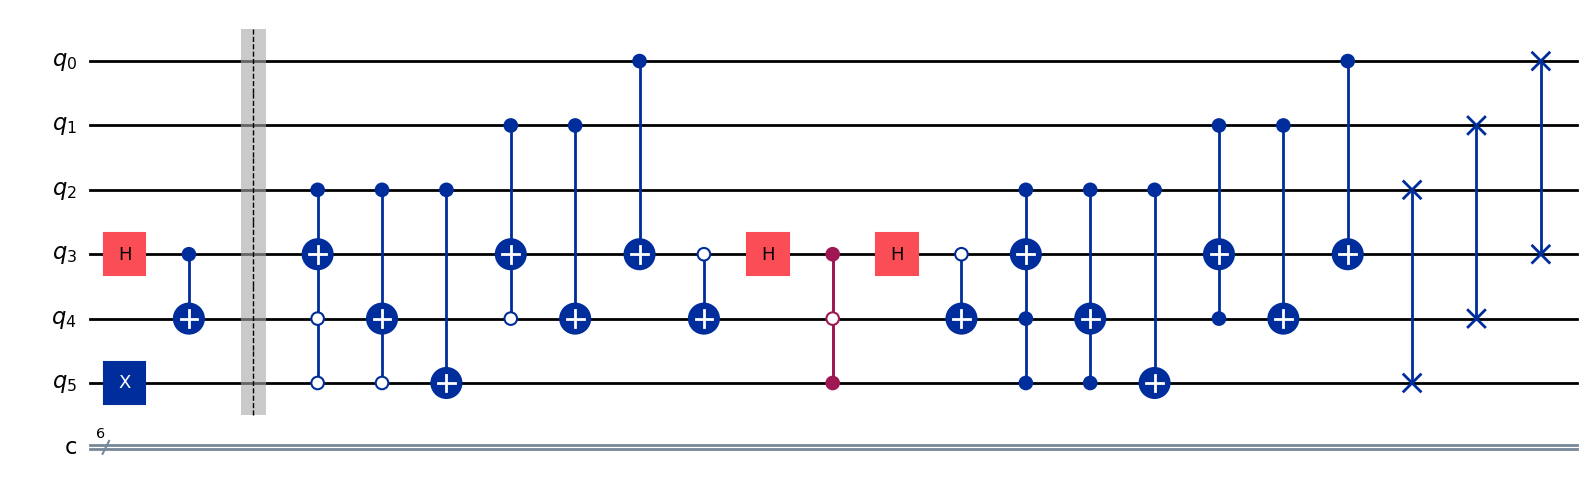

In [482]:
# Create the quantum circuit
qc = QuantumCircuit(num_input * 2, num_input * 2)

simulator = AerSimulator()

# Apply Hadamard coin operator
qc.h(num_input + 0)
for i in range(num_input - 2):
    qc.cx(num_input + 0, num_input + 1 + i)
qc.x(num_input * 2 - 1)
# done with initail setup
qc.barrier()

# states = [Statevector.from_instruction(qc)]
# print(f"Initial state: {states[0]}")
szegedy_step(qc)
qc.draw(output="mpl")


dict_keys(['000']) dict_values([np.float64(0.9999999999999982)])
dict_keys(['100', '111']) dict_values([np.float64(0.49999999999999845), np.float64(0.49999999999999845)])
dict_keys(['000', '010', '011']) dict_values([np.float64(0.49999999999999745), np.float64(0.24999999999999883), np.float64(0.24999999999999867)])
dict_keys(['100', '101', '110', '111']) dict_values([np.float64(0.12499999999999925), np.float64(0.37499999999999734), np.float64(0.3749999999999975), np.float64(0.12499999999999925)])
dict_keys(['000', '001', '010', '011']) dict_values([np.float64(0.12499999999999904), np.float64(0.12499999999999888), np.float64(0.37499999999999706), np.float64(0.3749999999999968)])
dict_keys(['100', '101', '110', '111']) dict_values([np.float64(0.1249999999999987), np.float64(0.624999999999994), np.float64(0.12499999999999858), np.float64(0.12499999999999878)])
dict_keys(['000', '010', '011']) dict_values([np.float64(0.749999999999991), np.float64(0.12499999999999845), np.float64(0.1249999

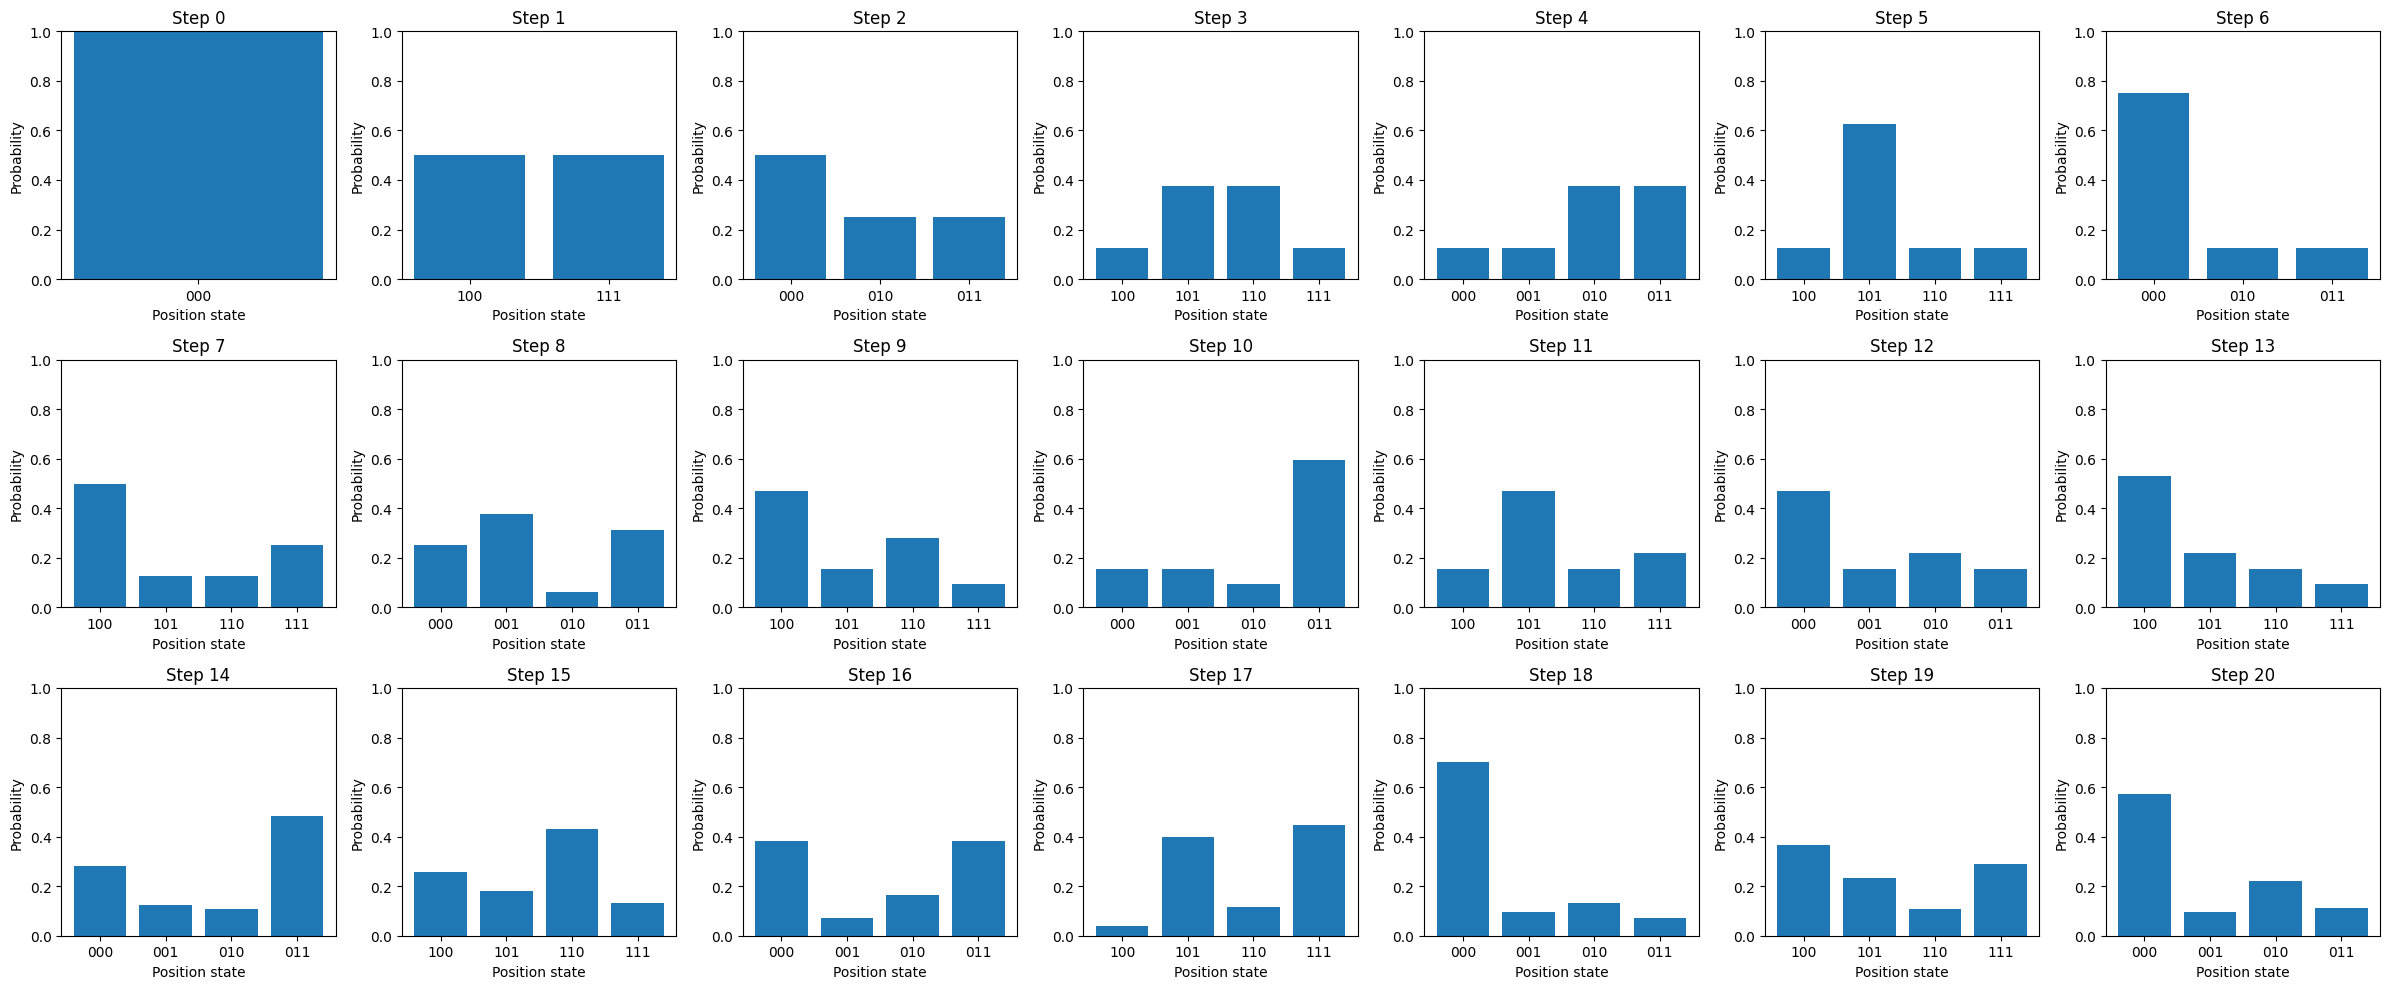

In [483]:
# Create the quantum circuit
qc = QuantumCircuit(num_input * 2, num_input * 2)

simulator = AerSimulator()

steps = 20

# Apply Hadamard coin operator
qc.h(num_input + 0)
for i in range(num_input - 2):
    qc.cx(num_input + 0, num_input + 1 + i)
qc.x(num_input * 2 - 1)
# done with initail setup
# qc.barrier()

states = []
szegedy_step(qc)
states.append(Statevector.from_instruction(qc))
for _ in range(steps):
    qc.h(num_input + 0)
    szegedy_step(qc)
    states.append(Statevector.from_instruction(qc))


fig, axs = plt.subplots(3, 7, figsize=(24, 10))
axs = axs.flatten()
for i, state in enumerate(states):
    probs = state.probabilities_dict()
    filtered = {}
    for key, val in probs.items():
        if val < 0.0001:
            continue
        pos = key[:num_input]
        filtered[pos] = filtered.get(pos, 0) + val
    print(filtered.keys(), filtered.values())
    axs[i].bar(filtered.keys(), filtered.values())
    axs[i].set_title(f"Step {i}")
    axs[i].set_ylim(0, 1)
    axs[i].set_xlabel("Position state")
    axs[i].set_ylabel("Probability")

plt.tight_layout()
plt.show()

# qc.draw(output="mpl")



Så man kan se stora tal för en vis step

Text(0, 0.5, 'Probability')

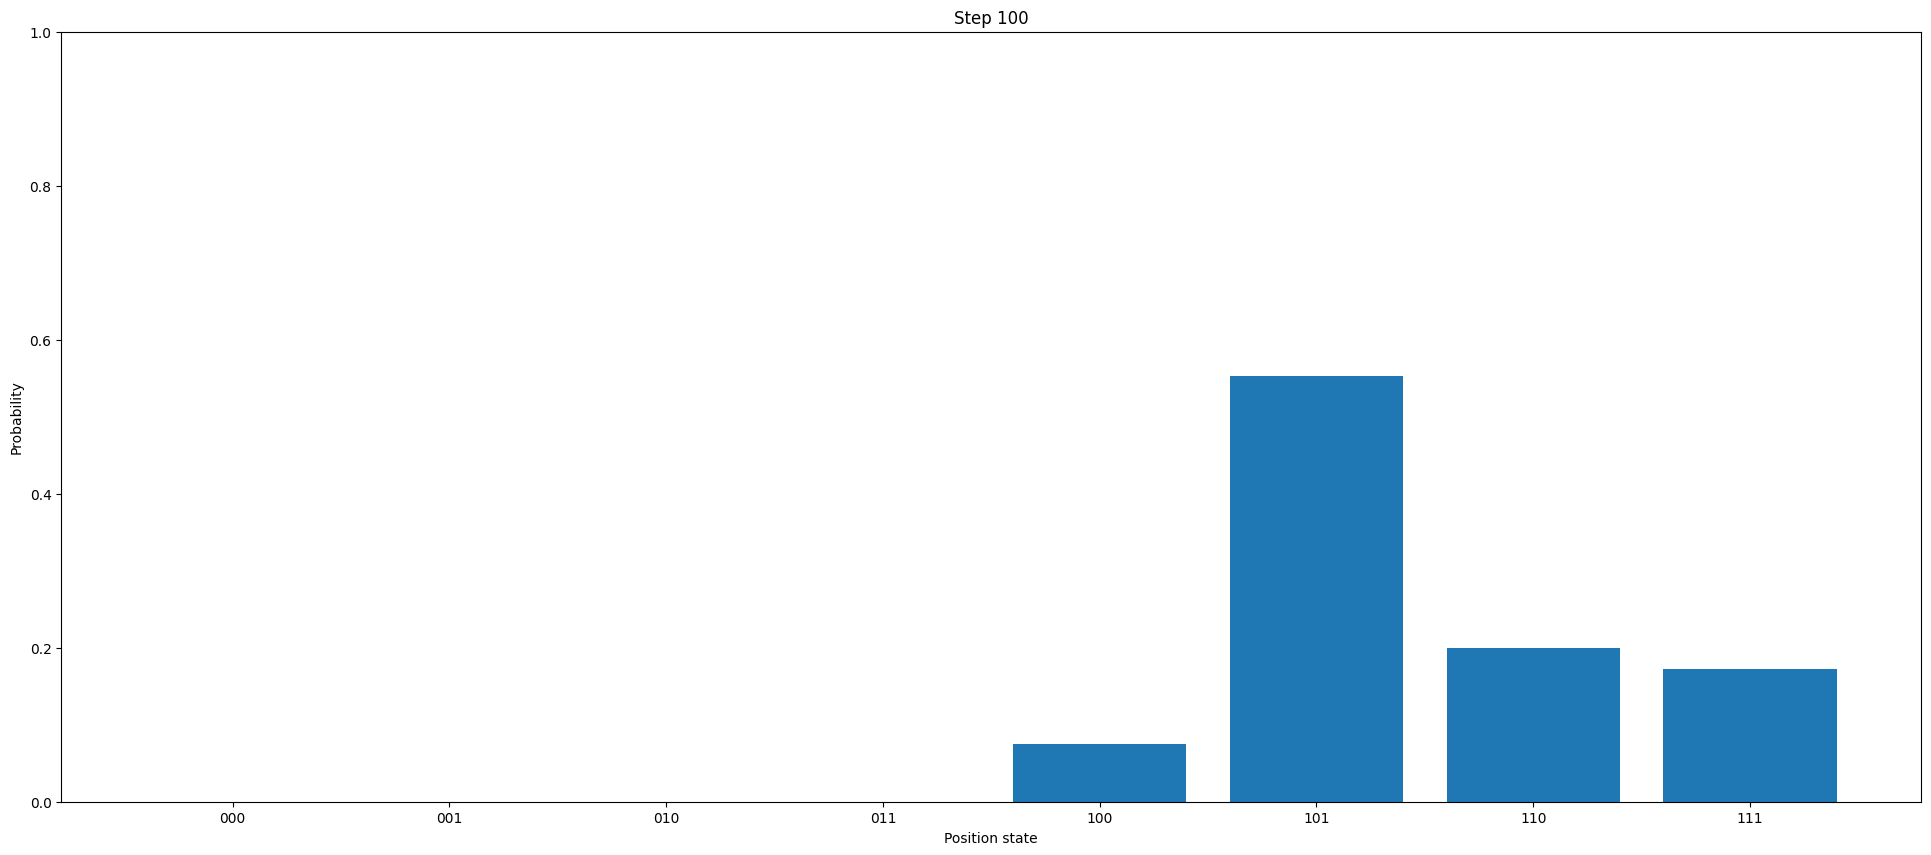

In [484]:
# Create the quantum circuit
qc = QuantumCircuit(num_input * 2, num_input * 2)

simulator = AerSimulator()

steps = 100

# Apply Hadamard coin operator
qc.h(num_input + 0)
for i in range(num_input - 2):
    qc.cx(num_input + 0, num_input + 1 + i)
qc.x(num_input * 2 - 1)
# done with initail setup
# qc.barrier()

szegedy_step(qc)
for _ in range(steps-1):
    qc.h(num_input + 0)
    szegedy_step(qc)

state = Statevector.from_instruction(qc)


fig, axs = plt.subplots(1, 1, figsize=(24, 10))

probs = state.probabilities_dict()
filtered = {}
for key, val in probs.items():
    pos = key[:num_input]
    filtered[pos] = filtered.get(pos, 0) + val

axs.bar(filtered.keys(), filtered.values())
axs.set_title(f"Step {steps}")
axs.set_ylim(0, 1)
axs.set_xlabel("Position state")
axs.set_ylabel("Probability")


